In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal

In [33]:
# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

# 平方根平均二乗誤差（Root mean square error）を計算
def rms_error(dataset, f):
    err = 0.0
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))

# 最小二乗法で解を求める
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return (f, ws)

def plotRmsError():
    # トレーニングセットとテストセットでの誤差の変化を表示
    df = DataFrame(columns=['Training set','Test set'])
    for m in range(0,10):   # 多項式の次数
        f, ws = resolve(train_set, m)
        train_error = rms_error(train_set, f)
        test_error = rms_error(test_set, f)
        df = df.append(
                Series([train_error, test_error],
                    index=['Training set','Test set']),
                ignore_index=True)
    df.plot(title='RMS Error', style=['-','--'], grid=True, ylim=(0,0.9))
    plt.show()
    return

In [34]:
# Main
#------------#
# Parameters #
#------------#
N=10            # サンプルを取得する位置 x の個数
M=[0,1,3,9]     # 多項式の次数


def RMS(N,M):
# if __name__ == '__main__':
    df_ws = DataFrame()

    # 多項式近似の曲線を求めて表示
    fig = plt.figure()
    for c, m in enumerate(M):
        f, ws = resolve(train_set, m)
        df_ws = df_ws.append(Series(ws,name="M=%d" % m))

        subplot = fig.add_subplot(2,2,c+1)
        subplot.set_xlim(-0.05,1.05)
        subplot.set_ylim(-1.5,1.5)
        subplot.set_title("M=%d" % m)

        # トレーニングセットを表示
        subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')

        # 真の曲線を表示
        linex = np.linspace(0,1,101)
        liney = np.sin(2*np.pi*linex)
        subplot.plot(linex, liney, color='green', linestyle='--')

        # 多項式近似の曲線を表示
        linex = np.linspace(0,1,101)
        liney = f(linex)
        label = "E(RMS)=%.2f" % rms_error(train_set, f)
        subplot.plot(linex, liney, color='red', label=label)
        subplot.legend(loc=1)

    # 係数の値を表示
    print "Table of the coefficients"
    print df_ws.transpose()

# 2.1 多項式近似と最小二乗法による推定


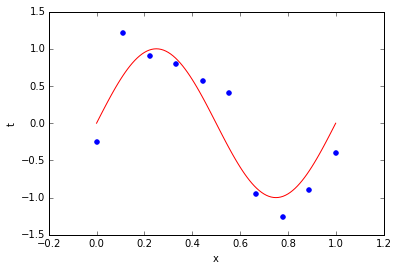

In [35]:
num  = 10
dataset = DataFrame(columns=['x','y'])
for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),ignore_index=True)

plt.scatter(dataset.x, dataset.y, marker='o', color='blue')
linex = np.linspace(0,1,101)
liney = np.sin(2*np.pi*linex)
plt.plot(linex, liney, color='r')

plt.xlabel('x')
plt.ylabel('t')

## 2.1.1 トレーニングセットの特徴変数と目的変数
* トレーニングセット: 青点。分析対象のデータ(x,t)
* t: 観測値、目的変数
* x: 観測点、特徴ベクトル or 特徴変数。分析対象の性質を特徴づける変数

### ゴール
* 観測点xを観測した時に、観測値tがいくらになるかを予測すること

## 2.1.2 多項式近似と誤差関数の設定
\begin{equation*} f(x) = w_0  + w_1 x + w_2 x^2 + \ldots + w_M x^M = \Sigma^M_{m=0} w_m x^m\end{equation*}

* w: パラメタ。これを学習して最適にしたい。

### どう最適化するか？

* 誤差を最小にする => 最小になる係数(w)を決定することがゴール
    * 最小二乗法と呼ばれる
\begin{equation*}E_D = \frac{1}{2}\sum^N_{n=1} \{f(x_n) - t_n\}^2\\
=\frac{1}{2}\sum^N_{n=1}(\sum^M_{m=0}w_m x^m_n - t_n)^2 \end{equation*}

* 平方根平均二乗誤差: Root Mean Square Errorでもおｋ

\begin{equation}E_{RMS} = \sqrt{\frac{2E_D}{N}}\end{equation}

## 2.1.3誤差関数を最小にする条件
* 下記を求める
\begin{equation}
\frac{\partial E_D}{\partial w_m}  = 0\hspace{3em} (m = 0, \ldots, M)
\end{equation}

## 2.1.4 サンプルコードによる確認
* こまけぇことはいいんだよ！
* w(求めたいパラメタ）は以下の式で成り立つ（ただしM < Nの場合）

\begin{equation}w = (\Phi^T\Phi)^{-1}\Phi^Tt\\
\Phi = \left[ 
\begin{array}{ccc}
x^0_1 & x^1_1 &\cdots & x^M_1\\
x^0_2 & x^1_2& \cdots & x^M_2\\
\vdots &\vdots & \ddots & \vdots \\
x^0_N & x^1_N & \cdots & x^M_N \\
\end{array} 
\right]
\end{equation}

Table of the coefficients
        M=0       M=1        M=3            M=9
0 -0.015401  0.569227   0.056376       0.078572
1       NaN -1.169255   7.332951     -97.201978
2       NaN       NaN -22.474669    2073.516614
3       NaN       NaN  15.010206  -16309.039648
4       NaN       NaN        NaN   66757.865889
5       NaN       NaN        NaN -159980.702297
6       NaN       NaN        NaN  233024.414757
7       NaN       NaN        NaN -203287.062136
8       NaN       NaN        NaN   97766.845953
9       NaN       NaN        NaN  -19948.921884


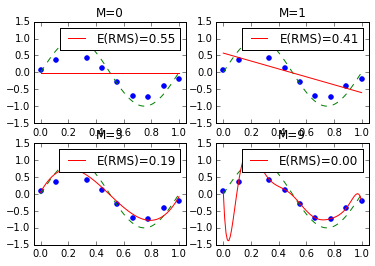

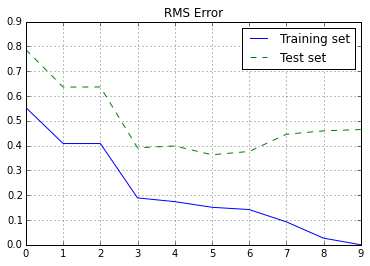

In [36]:
N = 10
train_set = create_dataset(N)
test_set = create_dataset(N)
df_ws = DataFrame()
RMS(N, M)
plotRmsError()

# 2.2 オーバーフィッティングの検出

## 2.2.1 トレーニングセットとテストセット

### 最適な次数とは？
* トレーニングセットだけではわからない。なぜなら正解のモデルがわからないから
* 特徴が多ければ多いほど、視覚的にわかりにくくなる
    
### どうするか？
* 新しいデータから予測値と観測値を比較する
* ...というのは難しいので、利用可能なデータをトレーニング用とテスト用にわける。

## 2.2.2 テストセットによる検証結果

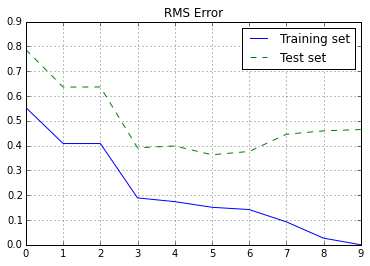

In [37]:
plotRmsError()

### 結果
* トレーニングセットにおける誤差は次数が大きくなれば０に近づく
* だが**テストセットでは、その限りではない！**
    * 次数4移行に変化はない -> 予測力は高まらない
    * **モデルの汎化能力**の限界　
    * トレーニングセットに特化しすぎたチューニング -> **オーバーフィッティング**
    
## 2.2.3 クロスバリデーションによる汎化能力の検証
### データを分ける際にしてはいけないこと
* トレーニングセット内のデータをテストセットに混ぜること

### クロスバリデーション
* 利用可能なデータを幾つかのグループに分ける（今回の場合、各次数をグルーピング）
* その１つのグループをテストセットとして用いた検証を行う(今回の場合、各次数の誤差を検証)
* 上記の検証を全グループで行い、検証結果を総合して判断する（今回の場合、次数を決定）

### 2.2.4 データ数によるオーバーフィッティングの変化
* データ数が少ない場合, 取得したデータが偶然にもってる特徴が目立ちがち
* データ数が多いほど本質的な特徴をとらえるので、オーバーフィッティングしにくい


Table of the coefficients
        M=0       M=1        M=3           M=9
0 -0.023798  0.938913  -0.138856     -0.260481
1       NaN -1.925422  11.340376     24.240952
2       NaN       NaN -33.328932   -297.287079
3       NaN       NaN  22.218066   2295.617230
4       NaN       NaN        NaN -10595.393150
5       NaN       NaN        NaN  29466.899556
6       NaN       NaN        NaN -50175.140455
7       NaN       NaN        NaN  51058.813690
8       NaN       NaN        NaN -28395.774247
9       NaN       NaN        NaN   6618.478623


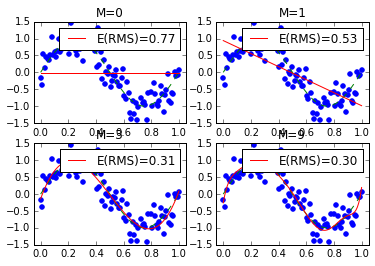

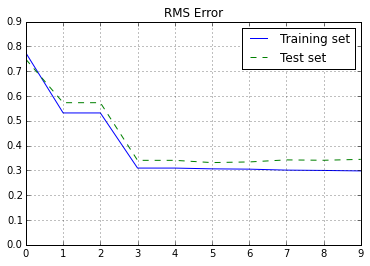

In [38]:
N = 100
train_set = create_dataset(N)
test_set = create_dataset(N)
df_ws = DataFrame()

RMS(N, M)
plotRmsError()